In [9]:
import sys
sys.path.append('../..')
from src.pomdp import *

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange
import pandas as pd
import numpy as np
import json

from viz_functions import *

In [3]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(0)

# Model, vf, and agent

In [2]:
model = Model.load_from_file('./Models/Alt_Wrap_GroundAir.pck')

In [4]:
vf = ValueFunction.load_from_file('./Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_165329/ValueFunctions/run-0-VF.gzip', model)

In [6]:
gpu_vf = vf.to_gpu()

[12/04/2023, 12:16:49] Sending Model to GPU...
[12/04/2023, 12:16:50]     > Done in 0.190s


In [11]:
a = Agent(model, gpu_vf)

# Single sim

In [15]:
seq_runtimes = []
for i in trange(100):
    sim_start_ts = datetime.now()
    sim_hist = a.simulate(
        max_steps=300,
        start_state=((361*30)+300),
        print_progress=False,
        print_stats=False)

    end_ts = datetime.now()
    seq_runtimes.append((end_ts - sim_start_ts).total_seconds())

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 0, 'Runtime (s)')

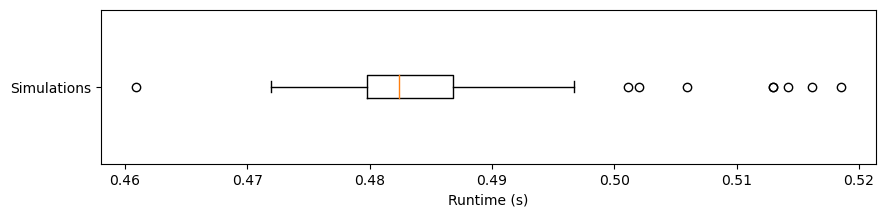

In [24]:
plt.figure(figsize=(10,2))
plt.boxplot(seq_runtimes, vert=False)

plt.yticks([1], labels=['Simulations'])
plt.xlabel('Runtime (s)')


# Parallel simulations

In [26]:
sim_counts = [1,10,50,100,500,1000]

par_runtimes = []

for s_count in tqdm(sim_counts):
    sim_start_ts = datetime.now()
    sim_hist = a.run_n_simulations_parallel(
        n=s_count,
        max_steps=300,
        start_state=[((361*30)+300)],
        print_progress=False,
        print_stats=False)

    end_ts = datetime.now()
    par_runtimes.append((end_ts - sim_start_ts).total_seconds())

  0%|          | 0/6 [00:00<?, ?it/s]

In [33]:
par_runtimes

[0.544205, 0.945105, 2.492833, 4.745828, 23.087507, 45.154367]

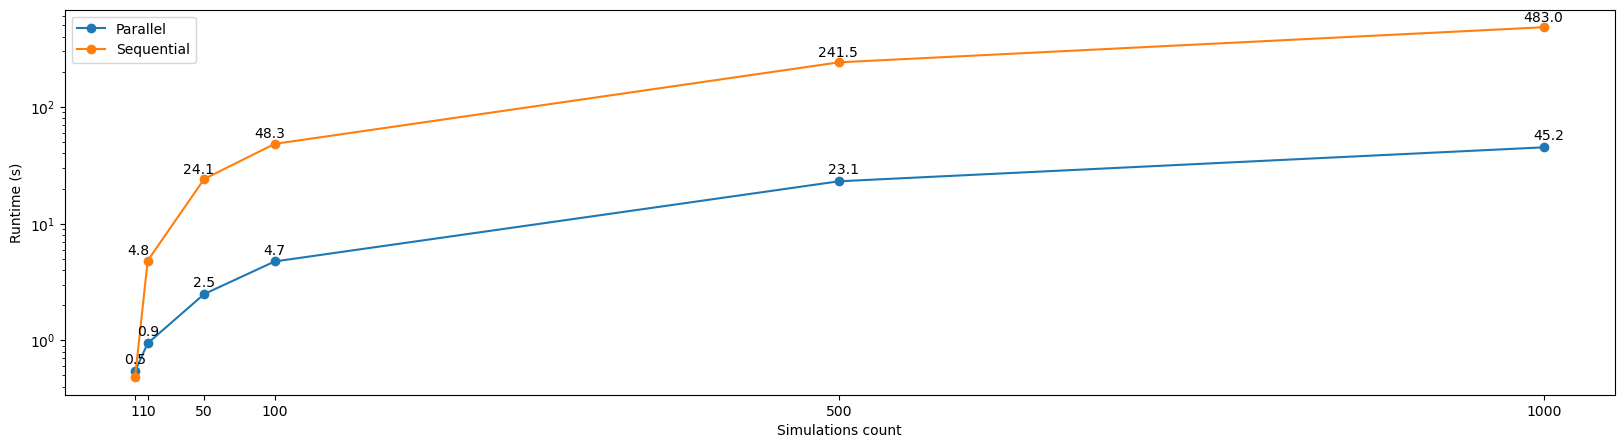

In [60]:
plt.figure(figsize=(20,5))

plt.plot(sim_counts, par_runtimes, marker='o', label='Parallel')
for x,y in zip(sim_counts, par_runtimes):
    plt.annotate(f'{y:.1f}', (x,y), xytext=(-8,3), textcoords='offset points', horizontalalignment='left', verticalalignment='bottom')

plt.plot(sim_counts, np.array(sim_counts)*0.483, marker='o', label='Sequential')
for x in sim_counts[1:]:
    y = x*0.483
    plt.annotate(f'{y:.1f}', xy=(x,y), xytext=(-15,2), textcoords='offset points', horizontalalignment='left', verticalalignment='bottom')

plt.xticks(sim_counts)

plt.ylabel('Runtime (s)')
plt.xlabel('Simulations count')
plt.yscale('log')
plt.legend()